In [1]:
from gs_quant.markets import PricingContext
from gs_quant.session import GsSession, Environment
from gs_quant.markets.portfolio import Portfolio
from gs_quant.instrument import IRSwap
from gs_quant.risk import CarryScenario, IRFwdRate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(Environment.PROD, client_id=None, client_secret=None, scopes=('run_analytics',))

In [3]:
# construct a portfolio of swaps with tenors 6m apart and resolve these trades

tenor = ['42m', '4y', '54m', '5y']
swap_port = [IRSwap('Pay', t, 'EUR', fixed_rate='ATM', floating_rate_frequency='6m', 
                    effective_date='6m', name='EUR6m'+t) for t in tenor]
port = Portfolio(swap_port)
port.resolve()

fwd_results = []
spot_results = []

# calculate the fwd rate under the assumption spot rates are held constant and that fwd rates are held constant.
# here we calculate the fwd rate every week forward in time.

with PricingContext():
    for time_shift in range(0, 120, 10):
        with PricingContext(is_async=True), CarryScenario(time_shift=time_shift, roll_to_fwds=True):
            fwd_results.append(port.calc(IRFwdRate))
        with PricingContext(is_async=True), CarryScenario(time_shift=time_shift, roll_to_fwds=False):
            spot_results.append(port.calc(IRFwdRate))

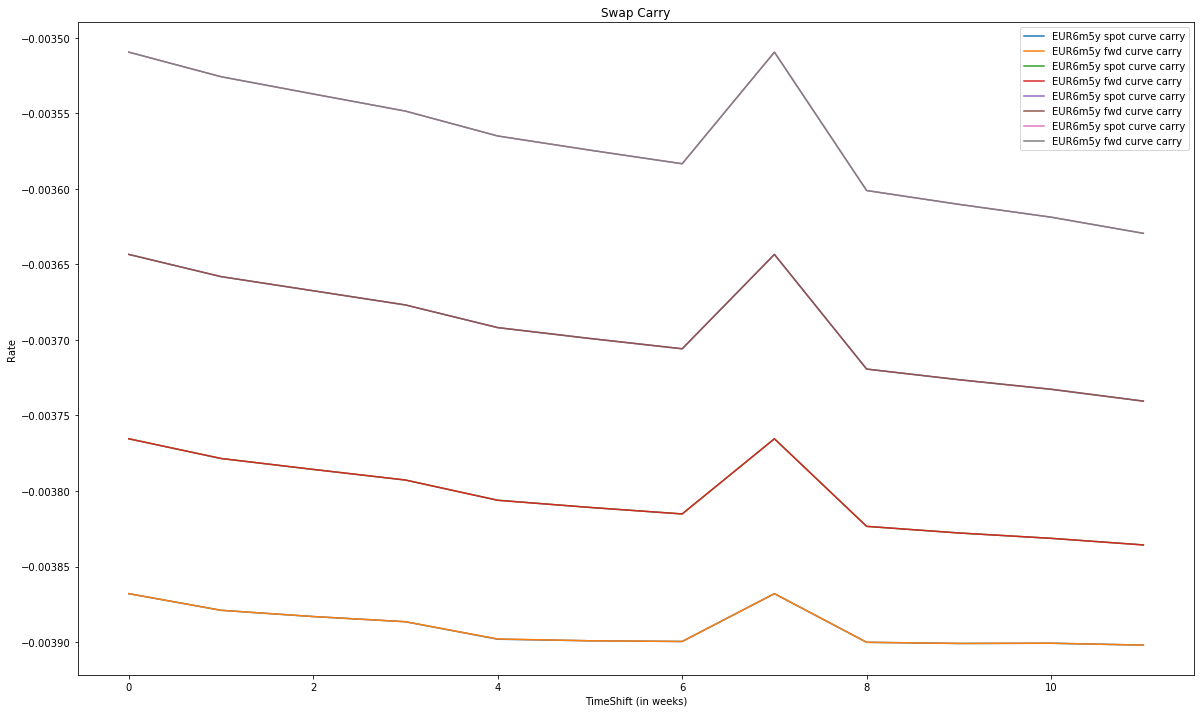

In [9]:
# graph the results.  Note that under the fwd rate constant assumption the fwd rate doesn't change, 
# whereas you see the effect of the rolldown of the curve in the spot rate constant assumption.
for swap in swap_port:
    s = pd.Series([p[swap.name] for p in spot_results], dtype=np.dtype(float))
    s.plot(figsize=(20, 12), title='Swap Carry', label='{} spot curve carry'.format(inst.name))
    f = pd.Series([p[swap.name] for p in fwd_results], dtype=np.dtype(float))
    f.plot(label='{} fwd curve carry'.format(inst.name))

plt.xlabel('TimeShift (in weeks)')
plt.ylabel('Rate')
plt.legend()